In [2]:

import gym
import random
import numpy as np
import torch
import torch.nn as nn
from IPython import display
from matplotlib import pyplot as plt
import cv2




     


In [ ]:
# customized weight initialization
def customized_weights_init(m):
    # compute the gain
    gain = nn.init.calculate_gain('relu')
    # init the convolutional layer
    if isinstance(m, nn.Conv2d):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)
    # init the linear layer
    if isinstance(m, nn.Linear):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)

In [ ]:
class DeepQNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layer, dim_hidden_layer, output_dim,number_of_actions):
        super(DeepQNet, self).__init__()

        """CODE HERE: construct your Deep neural network
        """
         # define the input dimension
        self.input_dim = input_dim

        # define the hidden dimension
        self.hidden_num = num_hidden_layer

        # define the number of the hidden layers
        self.hidden_dim = dim_hidden_layer

        # define the output dimension
        self.output_dim = output_dim
        self.number_of_actions=number_of_actions
        self.f = nn.Sequential(
            nn.Conv2d(input_dim[0], 32, 8, 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU()
        )

        self.dqn = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
      
 
    def forward(self, x):
        x = self.f(x)
        x = x.view(x.size(0), -1)
        x = self.dqn(x)
        return x
    
    def feature_size(self):
        return self.f((torch.zeros(1, *self.input_shape))).view(1, -1).size(1)


In [ ]:
class ReplayBuffer(object):
    """ Implement the Replay Buffer as a class, which contains:
            - self._data_buffer (list): a list variable to store all transition tuples.
            - add: a function to add new transition tuple into the buffer
            - sample_batch: a function to sample a batch training data from the Replay Buffer
    """
    def __init__(self, buffer_size):
        """Args:
               buffer_size (int): size of the replay buffer
        """
        # total size of the replay buffer
        self.total_size = buffer_size

        # create a list to store the transitions
        self._data_buffer = []
        self._next_idx = 0

    def __len__(self):
        return len(self._data_buffer)

    def add(self, obs, act, reward, next_obs, done):
        # create a tuple
        trans = (obs, act, reward, next_obs, done)

        # interesting implementation
        if self._next_idx >= len(self._data_buffer):
            self._data_buffer.append(trans)
        else:
            self._data_buffer[self._next_idx] = trans

        # increase the index
        self._next_idx = (self._next_idx + 1) % self.total_size

    def _encode_sample(self, indices):
        """ Function to fetch the state, action, reward, next state, and done arrays.
        
            Args:
                indices (list): list contains the index of all sampled transition tuples.
        """
        # lists for transitions
        obs_list, actions_list, rewards_list, next_obs_list, dones_list = [], [], [], [], []

        # collect the data
        for idx in indices:
            # get the single transition
            data = self._data_buffer[idx]
            obs, act, reward, next_obs, d = data
            # store to the list
            obs_list.append(np.array(obs, copy=False))
            actions_list.append(np.array(act, copy=False))
            rewards_list.append(np.array(reward, copy=False))
            next_obs_list.append(np.array(next_obs, copy=False))
            dones_list.append(np.array(d, copy=False))
        # return the sampled batch data as numpy arrays
        return np.array(obs_list), np.array(actions_list), np.array(rewards_list), np.array(next_obs_list), np.array(
            dones_list)

    def sample_batch(self, batch_size):
        """ Args:
                batch_size (int): size of the sampled batch data.
        """
        # sample indices with replaced
        indices = [np.random.randint(0, len(self._data_buffer)) for _ in range(batch_size)]
        return self._encode_sample(indices)

In [ ]:
class LinearSchedule(object):
    """ This schedule returns the value linearly"""
    def __init__(self, start_value, end_value, duration):
        # start value
        self._start_value = start_value
        # end value
        self._end_value = end_value
        # time steps that value changes from the start value to the end value
        self._duration = duration
        # difference between the start value and the end value
        self._schedule_amount = end_value - start_value
        

    def get_value(self, time):
        # logic: if time > duration, use the end value, else use the scheduled value
        """ CODE HERE: return the epsilon for each time step within the duration.
        """
        if time>self._duration:
            return self._end_value
        else:
            return self._start_value + self._schedule_amount * time / self._duration

      
        
        

       

In [ ]:
class DQNAgent(object):
    # initialize the agent
    def __init__(self,
                 params,
                 ):
        # save the parameters
        self.params = params

        # environment parameters
        self.action_dim = params['action_dim']
        self.obs_dim = params['observation_dim']
       

        # executable actions
        self.action_space = params['action_space']

        # create value network
        self.behavior_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                   num_hidden_layer=params['hidden_layer_num'],
                                   dim_hidden_layer=params['hidden_layer_dim'],
                                   output_dim=params['action_dim'])
        # create target network
        self.target_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                          num_hidden_layer=params['hidden_layer_num'],
                                          dim_hidden_layer=params['hidden_layer_dim'],
                                          output_dim=params['action_dim'])

        # initialize target network with behavior network
        self.behavior_policy_net.apply(customized_weights_init)
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

        # send the agent to a specific device: cpu or gpu
        self.device = torch.device("cpu")
        self.behavior_policy_net.to(self.device)
        self.target_policy_net.to(self.device)

        # optimizer
        self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(), lr=params['learning_rate'])

    # get action
    def get_action(self, obs, eps):
        if np.random.random() < eps:  # with probability eps, the agent selects a random action
            action = np.random.choice(self.action_space, 1)[0]
            return action
        else:  # with probability 1 - eps, the agent selects a greedy policy
            obs = self._arr_to_tensor(obs).view(1, -1)
            with torch.no_grad():
                q_values = self.behavior_policy_net(obs)
                action = q_values.max(dim=1)[1].item()
            return self.action_space[int(action)]

    # update behavior policy
    def update_behavior_policy(self, batch_data):
        # convert batch data to tensor and put them on device
        batch_data_tensor = self._batch_to_tensor(batch_data)

        # get the transition data
        obs_tensor = batch_data_tensor['obs']
        actions_tensor = batch_data_tensor['action']
        next_obs_tensor = batch_data_tensor['next_obs']
        rewards_tensor = batch_data_tensor['reward']
        dones_tensor = batch_data_tensor['done']

        """CODE HERE:
                Compute the predicted Q values using the behavior policy network
        """
        # compute the q value estimation using the behavior network
        q_current=self.behavior_policy_net(obs_tensor).gather(1,actions_tensor)
        # next_state_values=torch.zeros(self.params['batch_size'],device=self.device)
        next_state_values=self.target_policy_net(next_obs_tensor).max(1)[0].view(-1,1)
       
        # compute the TD target using the target network
        TD_target=rewards_tensor+self.params['gamma']*next_state_values*(1-dones_tensor)
      
        # compute the loss
        td_loss=torch.nn.functional.mse_loss(q_current,TD_target)
   
        # minimize the loss
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()

        return td_loss.item()

    # update target policy
    def update_target_policy(self):
        # hard update
        """CODE HERE: 
                Copy the behavior policy network to the target network
        """
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

    # auxiliary functions
    def _arr_to_tensor(self, arr):
        arr = np.array(arr)
        arr_tensor = torch.from_numpy(arr).float().to(self.device)
        return arr_tensor

    def _batch_to_tensor(self, batch_data):
        # store the tensor
        batch_data_tensor = {'obs': [], 'action': [], 'reward': [], 'next_obs': [], 'done': []}
        # get the numpy arrays
        obs_arr, action_arr, reward_arr, next_obs_arr, done_arr = batch_data
        # convert to tensors
        batch_data_tensor['obs'] = torch.tensor(obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['action'] = torch.tensor(action_arr).long().view(-1, 1).to(self.device)
        batch_data_tensor['reward'] = torch.tensor(reward_arr, dtype=torch.float32).view(-1, 1).to(self.device)
        batch_data_tensor['next_obs'] = torch.tensor(next_obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['done'] = torch.tensor(done_arr, dtype=torch.float32).view(-1, 1).to(self.device)

        return batch_data_tensor

In [ ]:
def train_dqn_agent(env, params):
    # create the DQN agent
    my_agent = DQNAgent(params)

    # create the epsilon-greedy schedule
    my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
                                 end_value=params['epsilon_end_value'],
                                 duration=params['epsilon_duration'])

    # create the replay buffer
    replay_buffer = ReplayBuffer(params['replay_buffer_size'])

    # training variables
    episode_t = 0
    rewards = []
    train_returns = []
    train_loss = []
    loss = 0

    # reset the environment
    obs, _ = env.reset()

    # start training
    pbar = tqdm.trange(params['total_training_time_step'])
    last_best_return = 0
    for t in pbar:
        # scheduled epsilon at time step t
        eps_t = my_schedule.get_value(t)
        # get one epsilon-greedy action
        action = my_agent.get_action(obs, eps_t)

        # step in the environment
        next_obs, reward, done, _, _ = env.step(action)
       

        # add to the buffer
        replay_buffer.add(obs, action, reward, next_obs, done)
        rewards.append(reward)

        # check termination
        if done or episode_t == params['max_time_step_per_episode'] - 1:
            # compute the return
            G = 0
            for r in reversed(rewards):
                G = r + params['gamma'] * G

            if G > last_best_return:
                torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}")

            # store the return
            train_returns.append(G)
            episode_idx = len(train_returns)

            # print the information
            pbar.set_description(
                f"Ep={episode_idx} | "
                f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                f"Eps={eps_t}"
            )

            # reset the environment
            episode_t, rewards = 0, []
            obs, _ = env.reset()
        else:
            # increment
            obs = next_obs
            episode_t += 1

        if t > params['start_training_step']:
            # update the behavior model
            if not np.mod(t, params['freq_update_behavior_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                batch_data=replay_buffer.sample_batch(params['batch_size'])
                
                train_loss.append(my_agent.update_behavior_policy(batch_data))

            # update the target model
            if not np.mod(t, params['freq_update_target_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                my_agent.update_target_policy()

    # save the results
    return train_returns, train_loss

In [ ]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
 
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)
    plt.grid()

    plt.show()

In [ ]:
def preprocessingofimage(s, ex, op):

    s = cv2.cvtColor(s, cv2.COLOR_RGB2GRAY)
    
    #Crop s[Up: Down, Left: right] 
    s = s[ex[0]:ex[2], ex[3]:ex[1]]
    
    # Convert to float, and normalized
    s = np.ascontiguousarray(s, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    s = cv2.resize(s, (op, op), interpolation = cv2.INTER_AREA)
    return s

def fstacking(sf, f, is_enter):

    if is_enter:
        sf = np.stack(arrays=[f, f, f, f])
        sf = sf
    else:
        sf[0] = sf[1]
        sf[1] = sf[2]
        sf[2] = sf[3]
        sf[3] = f
    
    return sf

def stack_fs(fs, state, is_enter=False):
    f = preprocessingofimage(state, (8, -12, -12, 4), 84)
    fs = fstacking(fs, f, is_enter)

    return fs

In [ ]:
if __name__ == '__main__':
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)
    torch.manual_seed(1234)

    # create environment
    my_env = gym.make('SpaceInvaders-v0')
    my_env.reset()
    plt.figure()
    plt.imshow(preprocessingofimage(my_env.reset(), (8, -12, -12, 4), 84), cmap="gray")
    plt.show()

    # create training parameters
    train_parameters = {
      'input_dim':(4,84,84),
      'observation_dim': 4,
        'action_dim': my_env.action_space.n,
        'action_space': my_env.action_space,
        'hidden_layer_num': 2,
        'hidden_layer_dim': 128,
        'gamma': 0.99999,
        
        'max_time_step_per_episode': 200,

        'total_training_time_step': 1_000_000,

        'epsilon_start_value': 1.0,
        'epsilon_end_value': 0.01,
        'epsilon_duration': 500_000,

        'replay_buffer_size': 500_000,
        'start_training_step': 2000,
        'freq_update_behavior_policy': 1000,
        'freq_update_target_policy': 10000,

        'batch_size': 128,
        'learning_rate': 1e-3,

        'model_name': "SpaceInvaders-v0"
    }

      # create experiment
    run_trial = 5
    train_returns={}
    train_loss={}
    for i in range(run_trial):

        train_returns[i], train_loss[i] = train_dqn_agent(my_env, train_parameters)
        min_value=min([len(return_value) for return_value in train_returns.values()])

    train_returns_clip=[]
    for trial_num,returns in train_returns.items():
        train_returns_clip.append(returns[:min_value])

In [ ]:
plot_curves([np.array(train_returns_clip)], ['  '], ['r'], 'return', '')

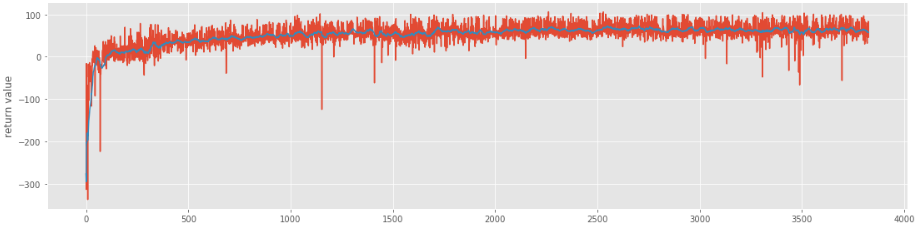

In [ ]:
plot_curves([np.array([l for l in train_loss.values()])],
            [''], ['r'], ' loss', '')

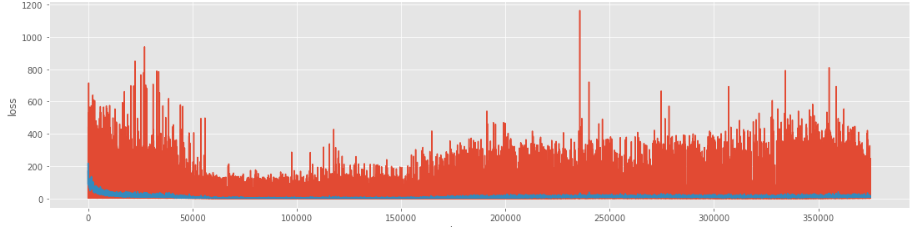